In [367]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
import sys
sys.path.insert(0, "..")


# Introdução

In [368]:
data = pd.read_csv("../data/creditcard.csv")

In [369]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [370]:
FEATURES = [f'V{i}' for i in range(1,29)] + ['Amount']
TARGET = 'Class'
SEED = 42


In [371]:
data['label'] = data.Class.apply(lambda x: "Fraud" if x==1 else "Not Fraud")
data['time_hr'] = np.floor(data['Time']/3600)
data['time_hr']= data['time_hr'].astype(int)

In [372]:
data_train, data_test = train_test_split(data, test_size=0.25, stratify=data[TARGET], random_state=SEED)

# EDA

## Describe

In [373]:
(100*data.label.value_counts()/data.shape[0]).to_frame().style.format("{:.2f}%")

,count
label,
Not Fraud,99.83%
Fraud,0.17%


In [374]:
data_train[FEATURES].describe().style.format('{:.3f}')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000
mean,-0.001,-0.001,-0.001,-0.002,0.000,-0.001,-0.001,-0.001,0.001,-0.000,-0.001,0.001,-0.001,-0.000,0.001,-0.001,0.000,-0.000,-0.000,-0.001,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,88.217
std,1.962,1.651,1.517,1.416,1.384,1.334,1.242,1.194,1.098,1.088,1.020,0.999,0.994,0.958,0.915,0.876,0.847,0.840,0.814,0.770,0.736,0.726,0.624,0.605,0.521,0.482,0.405,0.326,250.522
min,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,-13.434,-24.588,-4.797,-18.684,-5.792,-19.214,-4.499,-14.130,-25.163,-9.499,-7.214,-54.498,-34.830,-10.933,-44.808,-2.837,-10.295,-2.605,-22.566,-15.430,0.000
25%,-0.920,-0.600,-0.892,-0.849,-0.692,-0.769,-0.554,-0.208,-0.640,-0.536,-0.763,-0.404,-0.649,-0.426,-0.581,-0.470,-0.483,-0.499,-0.456,-0.212,-0.228,-0.542,-0.162,-0.355,-0.317,-0.327,-0.071,-0.053,5.640
50%,0.018,0.065,0.180,-0.022,-0.055,-0.275,0.040,0.023,-0.051,-0.094,-0.033,0.141,-0.015,0.049,0.048,0.065,-0.066,-0.003,0.004,-0.063,-0.030,0.006,-0.011,0.041,0.017,-0.052,0.001,0.011,22.000
75%,1.315,0.805,1.026,0.742,0.612,0.398,0.571,0.328,0.599,0.455,0.738,0.619,0.661,0.492,0.649,0.521,0.401,0.500,0.458,0.133,0.186,0.528,0.148,0.439,0.350,0.241,0.091,0.078,77.500
max,2.452,22.058,9.383,16.875,34.802,73.302,120.589,20.007,15.595,23.745,12.019,7.848,7.127,10.527,8.878,17.315,9.254,5.041,5.572,39.421,27.203,10.503,22.084,4.585,6.071,3.517,31.612,33.848,25691.160


In [375]:
data_train[FEATURES[:8]+["Amount"]].describe().style.format('{:.3f}')

,V1,V2,V3,V4,V5,V6,V7,V8,Amount
count,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000,213605.000
mean,-0.001,-0.001,-0.001,-0.002,0.000,-0.001,-0.001,-0.001,88.217
std,1.962,1.651,1.517,1.416,1.384,1.334,1.242,1.194,250.522
min,-56.408,-72.716,-48.326,-5.683,-113.743,-26.161,-43.557,-73.217,0.000
25%,-0.920,-0.600,-0.892,-0.849,-0.692,-0.769,-0.554,-0.208,5.640
50%,0.018,0.065,0.180,-0.022,-0.055,-0.275,0.040,0.023,22.000
75%,1.315,0.805,1.026,0.742,0.612,0.398,0.571,0.328,77.500
max,2.452,22.058,9.383,16.875,34.802,73.302,120.589,20.007,25691.160


## Scatter Plot

<Axes: xlabel='V4', ylabel='V14'>

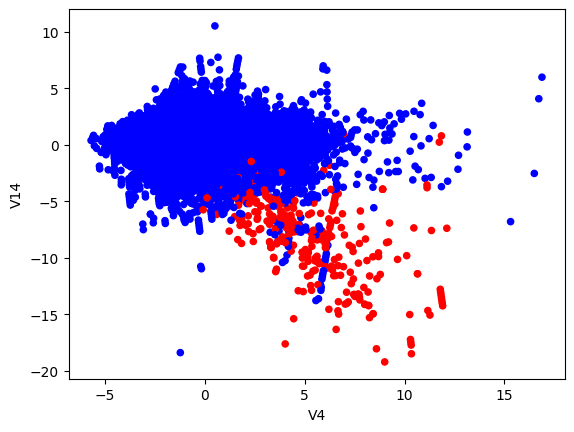

In [376]:
col = data_train.Class.map({0:'b', 1:'r'})
data_train.plot.scatter(x='V4',y='V14',c=col)

## Temporal Stability

In [377]:
from src.report import plot_time_stab, bin_var, display_side_by_side

In [378]:
data_train['time_hr'] = np.floor(data_train['Time']/3600)
data_train['time_hr']= data_train['time_hr'].astype(int)

In [379]:
data_agg_time = data_train.groupby(['time_hr']).agg(avg_amount=('Amount','mean'),
                              count=('Time','count'),
                              bad=('Class','sum')
                              ).reset_index()

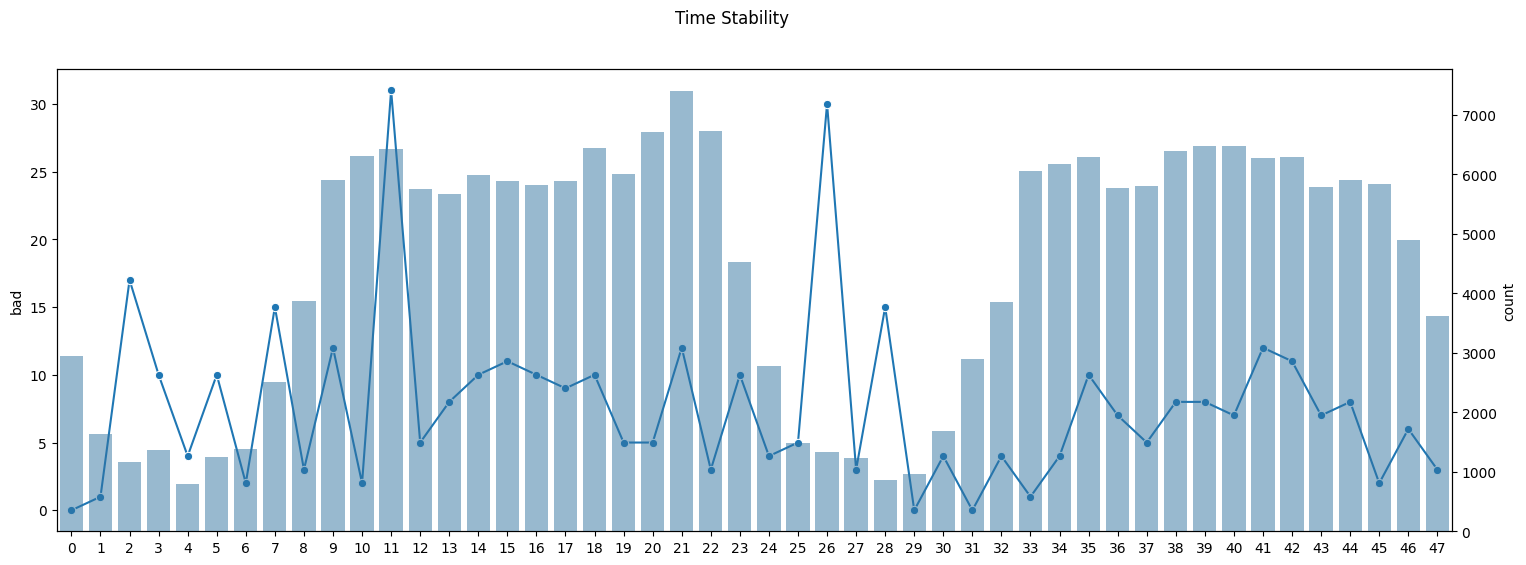

In [380]:
plot_time_stab(data_agg_time)

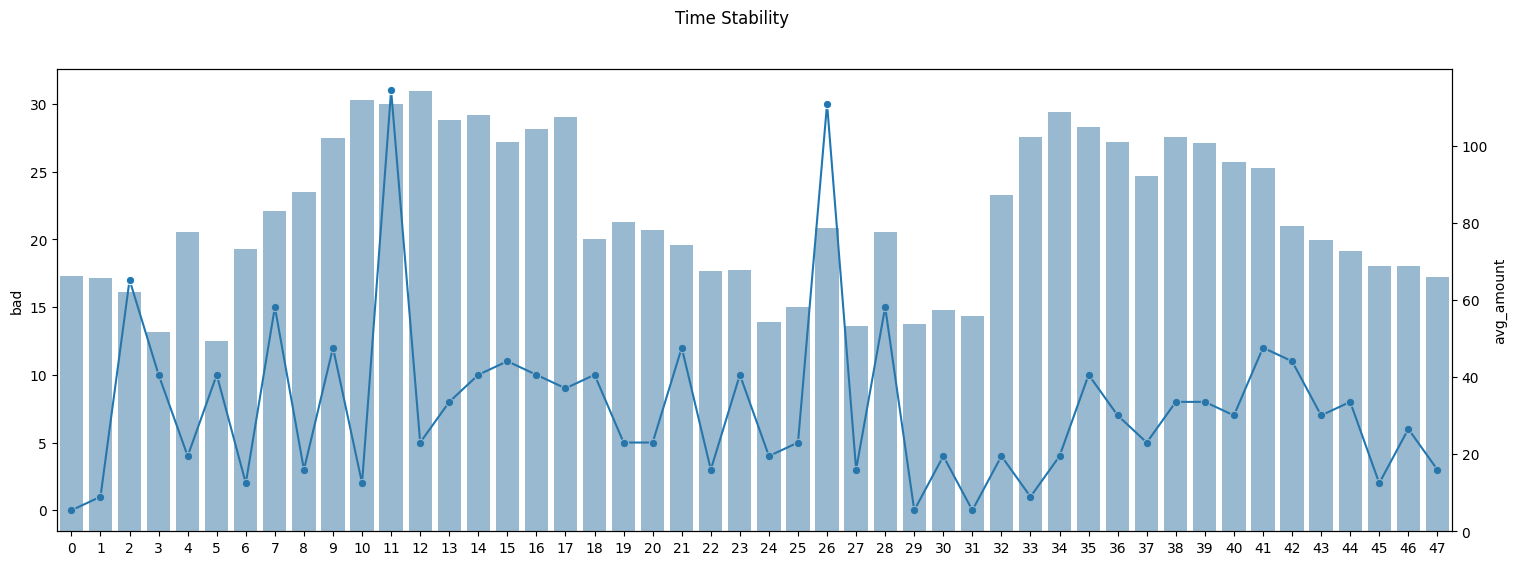

In [381]:
plot_time_stab(data_agg_time, bar_y_col='avg_amount')

## Binned Variables

In [382]:
def _bin_var(data, col, n_bins=10): 
    df = data.copy()
    col_binned = col+'_binned'
    cmap = sns.light_palette("red", as_cmap=True)
    df[col_binned] = pd.qcut(df[col],q=n_bins)
    df_agg = df.groupby(col_binned).agg(
                              count=(col,'count'),
                              bad=('Class','sum')
                              ).reset_index()
    df_agg['bad_rate'] = df_agg.bad/df_agg['count']
    df_agg['bad_distr'] = df_agg.bad/df_agg.bad.sum()
    view  = df_agg.style.background_gradient(subset=['bad_rate','bad_distr'],cmap=cmap,vmax=1).format("{:.3f}",subset=["bad_rate","bad_distr"])
    return view

In [383]:
binned_dfs = []
for f in FEATURES:
    print(f)
    binned_dfs.append(bin_var(data,f))
    display(bin_var(data,f))


V1


,V1_binned,count,bad,bad_rate,bad_distr
0,"(-56.409, -1.893]",28481,276,0.009691,0.560976
1,"(-1.893, -1.135]",28481,50,0.001756,0.101626
2,"(-1.135, -0.747]",28480,25,0.000878,0.050813
3,"(-0.747, -0.427]",28481,17,0.000597,0.034553
4,"(-0.427, 0.0181]",28481,20,0.000702,0.040650
5,"(0.0181, 1.035]",28480,53,0.001861,0.107724
6,"(1.035, 1.225]",28481,27,0.000948,0.054878
7,"(1.225, 1.695]",28480,10,0.000351,0.020325
8,"(1.695, 2.015]",28481,12,0.000421,0.024390
9,"(2.015, 2.455]",28481,2,0.000070,0.004065


V2


,V2_binned,count,bad,bad_rate,bad_distr
0,"(-72.717, -1.36]",28481,23,0.000808,0.046748
1,"(-1.36, -0.791]",28481,9,0.000316,0.018293
2,"(-0.791, -0.436]",28480,8,0.000281,0.016260
3,"(-0.436, -0.154]",28481,7,0.000246,0.014228
4,"(-0.154, 0.0655]",28481,11,0.000386,0.022358
5,"(0.0655, 0.303]",28480,6,0.000211,0.012195
6,"(0.303, 0.637]",28481,17,0.000597,0.034553
7,"(0.637, 0.957]",28480,16,0.000562,0.032520
8,"(0.957, 1.327]",28481,39,0.001369,0.079268
9,"(1.327, 22.058]",28481,356,0.012500,0.723577


V3


,V3_binned,count,bad,bad_rate,bad_distr
0,"(-48.327, -1.803]",28481,389,0.013658,0.790650
1,"(-1.803, -1.169]",28481,28,0.000983,0.056911
2,"(-1.169, -0.617]",28480,20,0.000702,0.040650
3,"(-0.617, -0.199]",28481,17,0.000597,0.034553
4,"(-0.199, 0.18]",28481,9,0.000316,0.018293
5,"(0.18, 0.497]",28480,6,0.000211,0.012195
6,"(0.497, 0.844]",28481,8,0.000281,0.016260
7,"(0.844, 1.216]",28480,9,0.000316,0.018293
8,"(1.216, 1.676]",28481,2,0.000070,0.004065
9,"(1.676, 9.383]",28481,4,0.000140,0.008130


V4


,V4_binned,count,bad,bad_rate,bad_distr
0,"(-5.684, -1.656]",28481,0,0.000000,0.000000
1,"(-1.656, -1.066]",28481,2,0.000070,0.004065
2,"(-1.066, -0.696]",28480,1,0.000035,0.002033
3,"(-0.696, -0.394]",28481,5,0.000176,0.010163
4,"(-0.394, -0.0198]",28481,5,0.000176,0.010163
5,"(-0.0198, 0.285]",28480,10,0.000351,0.020325
6,"(0.285, 0.559]",28481,9,0.000316,0.018293
7,"(0.559, 0.986]",28480,13,0.000456,0.026423
8,"(0.986, 1.483]",28481,25,0.000878,0.050813
9,"(1.483, 16.875]",28481,422,0.014817,0.857724


V5


,V5_binned,count,bad,bad_rate,bad_distr
0,"(-113.744, -1.302]",28481,256,0.008988,0.520325
1,"(-1.302, -0.86]",28481,34,0.001194,0.069106
2,"(-0.86, -0.544]",28480,27,0.000948,0.054878
3,"(-0.544, -0.29]",28481,18,0.000632,0.036585
4,"(-0.29, -0.0543]",28481,16,0.000562,0.032520
5,"(-0.0543, 0.187]",28480,15,0.000527,0.030488
6,"(0.187, 0.457]",28481,21,0.000737,0.042683
7,"(0.457, 0.802]",28481,24,0.000843,0.048780
8,"(0.802, 1.408]",28480,33,0.001159,0.067073
9,"(1.408, 34.802]",28481,48,0.001685,0.097561


V6


,V6_binned,count,bad,bad_rate,bad_distr
0,"(-26.162000000000003, -1.167]",28481,284,0.009972,0.577236
1,"(-1.167, -0.878]",28481,32,0.001124,0.065041
2,"(-0.878, -0.668]",28480,22,0.000772,0.044715
3,"(-0.668, -0.479]",28481,26,0.000913,0.052846
4,"(-0.479, -0.274]",28481,21,0.000737,0.042683
5,"(-0.274, -0.0482]",28480,25,0.000878,0.050813
6,"(-0.0482, 0.223]",28481,19,0.000667,0.038618
7,"(0.223, 0.629]",28480,15,0.000527,0.030488
8,"(0.629, 1.509]",28481,27,0.000948,0.054878
9,"(1.509, 73.302]",28481,21,0.000737,0.042683


V7


,V7_binned,count,bad,bad_rate,bad_distr
0,"(-43.558, -1.078]",28481,364,0.012780,0.739837
1,"(-1.078, -0.683]",28481,23,0.000808,0.046748
2,"(-0.683, -0.426]",28480,7,0.000246,0.014228
3,"(-0.426, -0.159]",28481,6,0.000211,0.012195
4,"(-0.159, 0.0401]",28481,11,0.000386,0.022358
5,"(0.0401, 0.214]",28480,8,0.000281,0.016260
6,"(0.214, 0.446]",28481,20,0.000702,0.040650
7,"(0.446, 0.698]",28480,10,0.000351,0.020325
8,"(0.698, 1.039]",28481,10,0.000351,0.020325
9,"(1.039, 120.589]",28481,33,0.001159,0.067073


V8


,V8_binned,count,bad,bad_rate,bad_distr
0,"(-73.218, -0.459]",28481,93,0.003265,0.189024
1,"(-0.459, -0.266]",28481,21,0.000737,0.042683
2,"(-0.266, -0.158]",28480,13,0.000456,0.026423
3,"(-0.158, -0.0661]",28481,13,0.000456,0.026423
4,"(-0.0661, 0.0224]",28481,12,0.000421,0.024390
5,"(0.0224, 0.12]",28480,21,0.000737,0.042683
6,"(0.12, 0.243]",28481,19,0.000667,0.038618
7,"(0.243, 0.436]",28480,27,0.000948,0.054878
8,"(0.436, 0.769]",28481,55,0.001931,0.111789
9,"(0.769, 20.007]",28481,218,0.007654,0.443089


V9


,V9_binned,count,bad,bad_rate,bad_distr
0,"(-13.434999999999999, -1.294]",28481,327,0.011481,0.664634
1,"(-1.294, -0.809]",28481,38,0.001334,0.077236
2,"(-0.809, -0.502]",28480,29,0.001018,0.058943
3,"(-0.502, -0.258]",28481,18,0.000632,0.036585
4,"(-0.258, -0.0514]",28481,19,0.000667,0.038618
5,"(-0.0514, 0.176]",28480,14,0.000492,0.028455
6,"(0.176, 0.446]",28481,10,0.000351,0.020325
7,"(0.446, 0.792]",28480,12,0.000421,0.024390
8,"(0.792, 1.302]",28481,18,0.000632,0.036585
9,"(1.302, 15.595]",28481,7,0.000246,0.014228


V10


,V10_binned,count,bad,bad_rate,bad_distr
0,"(-24.589000000000002, -1.032]",28481,417,0.014641,0.847561
1,"(-1.032, -0.666]",28481,12,0.000421,0.024390
2,"(-0.666, -0.426]",28480,7,0.000246,0.014228
3,"(-0.426, -0.248]",28481,7,0.000246,0.014228
4,"(-0.248, -0.0929]",28481,7,0.000246,0.014228
5,"(-0.0929, 0.0595]",28480,6,0.000211,0.012195
6,"(0.0595, 0.27]",28481,9,0.000316,0.018293
7,"(0.27, 0.648]",28480,11,0.000386,0.022358
8,"(0.648, 1.12]",28481,7,0.000246,0.014228
9,"(1.12, 23.745]",28481,9,0.000316,0.018293


V11


,V11_binned,count,bad,bad_rate,bad_distr
0,"(-4.798, -1.289]",28481,7,0.000246,0.014228
1,"(-1.289, -0.917]",28481,6,0.000211,0.012195
2,"(-0.917, -0.613]",28480,5,0.000176,0.010163
3,"(-0.613, -0.317]",28481,10,0.000351,0.020325
4,"(-0.317, -0.0328]",28481,3,0.000105,0.006098
5,"(-0.0328, 0.268]",28480,10,0.000351,0.020325
6,"(0.268, 0.579]",28481,9,0.000316,0.018293
7,"(0.579, 0.913]",28480,15,0.000527,0.030488
8,"(0.913, 1.319]",28481,23,0.000808,0.046748
9,"(1.319, 12.019]",28481,404,0.014185,0.821138


V12


,V12_binned,count,bad,bad_rate,bad_distr
0,"(-18.685000000000002, -1.148]",28481,414,0.014536,0.841463
1,"(-1.148, -0.573]",28481,23,0.000808,0.046748
2,"(-0.573, -0.272]",28481,20,0.000702,0.040650
3,"(-0.272, -0.0505]",28480,8,0.000281,0.016260
4,"(-0.0505, 0.14]",28481,6,0.000211,0.012195
5,"(0.14, 0.325]",28480,7,0.000246,0.014228
6,"(0.325, 0.516]",28481,3,0.000105,0.006098
7,"(0.516, 0.731]",28480,3,0.000105,0.006098
8,"(0.731, 1.017]",28481,6,0.000211,0.012195
9,"(1.017, 7.848]",28481,2,0.000070,0.004065


V13


,V13_binned,count,bad,bad_rate,bad_distr
0,"(-5.793, -1.28]",28481,74,0.002598,0.150407
1,"(-1.28, -0.825]",28481,67,0.002352,0.136179
2,"(-0.825, -0.497]",28480,39,0.001369,0.079268
3,"(-0.497, -0.24]",28481,36,0.001264,0.073171
4,"(-0.24, -0.0136]",28481,33,0.001159,0.067073
5,"(-0.0136, 0.229]",28480,37,0.001299,0.075203
6,"(0.229, 0.505]",28481,52,0.001826,0.105691
7,"(0.505, 0.829]",28480,58,0.002037,0.117886
8,"(0.829, 1.252]",28481,41,0.001440,0.083333
9,"(1.252, 7.127]",28481,55,0.001931,0.111789


V14


,V14_binned,count,bad,bad_rate,bad_distr
0,"(-19.215, -1.004]",28481,445,0.015624,0.904472
1,"(-1.004, -0.567]",28481,12,0.000421,0.024390
2,"(-0.567, -0.312]",28480,7,0.000246,0.014228
3,"(-0.312, -0.12]",28481,3,0.000105,0.006098
4,"(-0.12, 0.0506]",28481,3,0.000105,0.006098
5,"(0.0506, 0.216]",28480,3,0.000105,0.006098
6,"(0.216, 0.394]",28481,4,0.000140,0.008130
7,"(0.394, 0.609]",28480,2,0.000070,0.004065
8,"(0.609, 0.981]",28481,3,0.000105,0.006098
9,"(0.981, 10.527]",28481,10,0.000351,0.020325


V15


,V15_binned,count,bad,bad_rate,bad_distr
0,"(-4.5, -1.174]",28481,74,0.002598,0.150407
1,"(-1.174, -0.749]",28481,37,0.001299,0.075203
2,"(-0.749, -0.439]",28480,39,0.001369,0.079268
3,"(-0.439, -0.189]",28481,66,0.002317,0.134146
4,"(-0.189, 0.0481]",28481,55,0.001931,0.111789
5,"(0.0481, 0.272]",28503,30,0.001053,0.060976
6,"(0.272, 0.514]",28458,45,0.001581,0.091463
7,"(0.514, 0.795]",28480,47,0.001650,0.095528
8,"(0.795, 1.124]",28481,52,0.001826,0.105691
9,"(1.124, 8.878]",28481,47,0.001650,0.095528


V16


,V16_binned,count,bad,bad_rate,bad_distr
0,"(-14.131, -1.059]",28481,377,0.013237,0.766260
1,"(-1.059, -0.616]",28481,21,0.000737,0.042683
2,"(-0.616, -0.343]",28480,9,0.000316,0.018293
3,"(-0.343, -0.125]",28481,3,0.000105,0.006098
4,"(-0.125, 0.0664]",28481,5,0.000176,0.010163
5,"(0.0664, 0.242]",28480,9,0.000316,0.018293
6,"(0.242, 0.426]",28481,9,0.000316,0.018293
7,"(0.426, 0.641]",28480,11,0.000386,0.022358
8,"(0.641, 0.991]",28481,14,0.000492,0.028455
9,"(0.991, 17.315]",28481,34,0.001194,0.069106


V17


,V17_binned,count,bad,bad_rate,bad_distr
0,"(-25.164, -0.804]",28481,378,0.013272,0.768293
1,"(-0.804, -0.576]",28481,1,0.000035,0.002033
2,"(-0.576, -0.397]",28480,3,0.000105,0.006098
3,"(-0.397, -0.236]",28481,2,0.000070,0.004065
4,"(-0.236, -0.0657]",28481,7,0.000246,0.014228
5,"(-0.0657, 0.105]",28480,6,0.000211,0.012195
6,"(0.105, 0.297]",28481,8,0.000281,0.016260
7,"(0.297, 0.519]",28480,7,0.000246,0.014228
8,"(0.519, 0.909]",28481,21,0.000737,0.042683
9,"(0.909, 9.254]",28481,59,0.002072,0.119919


V18


,V18_binned,count,bad,bad_rate,bad_distr
0,"(-9.5, -0.977]",28481,293,0.010288,0.595528
1,"(-0.977, -0.627]",28481,27,0.000948,0.054878
2,"(-0.627, -0.386]",28480,13,0.000456,0.026423
3,"(-0.386, -0.186]",28481,10,0.000351,0.020325
4,"(-0.186, -0.00364]",28481,20,0.000702,0.040650
5,"(-0.00364, 0.182]",28480,17,0.000597,0.034553
6,"(0.182, 0.383]",28481,24,0.000843,0.048780
7,"(0.383, 0.637]",28480,17,0.000597,0.034553
8,"(0.637, 1.02]",28481,20,0.000702,0.040650
9,"(1.02, 5.041]",28481,51,0.001791,0.103659


V19


,V19_binned,count,bad,bad_rate,bad_distr
0,"(-7.215000000000001, -0.986]",28481,75,0.002633,0.152439
1,"(-0.986, -0.583]",28481,25,0.000878,0.050813
2,"(-0.583, -0.345]",28480,21,0.000737,0.042683
3,"(-0.345, -0.162]",28481,16,0.000562,0.032520
4,"(-0.162, 0.00373]",28481,14,0.000492,0.028455
5,"(0.00373, 0.168]",28480,24,0.000843,0.048780
6,"(0.168, 0.348]",28481,21,0.000737,0.042683
7,"(0.348, 0.586]",28480,35,0.001229,0.071138
8,"(0.586, 0.954]",28481,59,0.002072,0.119919
9,"(0.954, 5.592]",28481,202,0.007092,0.410569


V20


,V20_binned,count,bad,bad_rate,bad_distr
0,"(-54.498999999999995, -0.39]",28481,80,0.002809,0.162602
1,"(-0.39, -0.251]",28481,16,0.000562,0.032520
2,"(-0.251, -0.179]",28480,22,0.000772,0.044715
3,"(-0.179, -0.121]",28481,21,0.000737,0.042683
4,"(-0.121, -0.0625]",28481,18,0.000632,0.036585
5,"(-0.0625, 0.00431]",28480,21,0.000737,0.042683
6,"(0.00431, 0.0834]",28481,19,0.000667,0.038618
7,"(0.0834, 0.196]",28480,22,0.000772,0.044715
8,"(0.196, 0.445]",28481,80,0.002809,0.162602
9,"(0.445, 39.421]",28481,193,0.006776,0.392276


V21


,V21_binned,count,bad,bad_rate,bad_distr
0,"(-34.830999999999996, -0.367]",28481,70,0.002458,0.142276
1,"(-0.367, -0.266]",28481,14,0.000492,0.028455
2,"(-0.266, -0.188]",28480,1,0.000035,0.002033
3,"(-0.188, -0.106]",28481,13,0.000456,0.026423
4,"(-0.106, -0.0295]",28481,15,0.000527,0.030488
5,"(-0.0295, 0.0504]",28480,11,0.000386,0.022358
6,"(0.0504, 0.138]",28481,15,0.000527,0.030488
7,"(0.138, 0.235]",28480,19,0.000667,0.038618
8,"(0.235, 0.376]",28481,35,0.001229,0.071138
9,"(0.376, 27.203]",28481,299,0.010498,0.607724


V22


,V22_binned,count,bad,bad_rate,bad_distr
0,"(-10.934, -0.867]",28481,66,0.002317,0.134146
1,"(-0.867, -0.642]",28481,35,0.001229,0.071138
2,"(-0.642, -0.434]",28480,46,0.001615,0.093496
3,"(-0.434, -0.202]",28481,47,0.001650,0.095528
4,"(-0.202, 0.00678]",28481,44,0.001545,0.089431
5,"(0.00678, 0.201]",28480,43,0.001510,0.087398
6,"(0.201, 0.413]",28481,45,0.001580,0.091463
7,"(0.413, 0.649]",28480,47,0.001650,0.095528
8,"(0.649, 0.915]",28481,44,0.001545,0.089431
9,"(0.915, 10.503]",28481,75,0.002633,0.152439


V23


,V23_binned,count,bad,bad_rate,bad_distr
0,"(-44.809, -0.329]",28481,130,0.004564,0.264228
1,"(-0.329, -0.204]",28481,47,0.001650,0.095528
2,"(-0.204, -0.126]",28480,42,0.001475,0.085366
3,"(-0.126, -0.0651]",28481,28,0.000983,0.056911
4,"(-0.0651, -0.0112]",28481,29,0.001018,0.058943
5,"(-0.0112, 0.0448]",28480,21,0.000737,0.042683
6,"(0.0448, 0.109]",28481,23,0.000808,0.046748
7,"(0.109, 0.194]",28480,26,0.000913,0.052846
8,"(0.194, 0.339]",28481,28,0.000983,0.056911
9,"(0.339, 22.528]",28481,118,0.004143,0.239837


V24


,V24_binned,count,bad,bad_rate,bad_distr
0,"(-2.838, -0.87]",28481,40,0.001404,0.081301
1,"(-0.87, -0.444]",28481,80,0.002809,0.162602
2,"(-0.444, -0.264]",28480,65,0.002282,0.132114
3,"(-0.264, -0.0458]",28481,66,0.002317,0.134146
4,"(-0.0458, 0.041]",28481,33,0.001159,0.067073
5,"(0.041, 0.166]",28480,51,0.001791,0.103659
6,"(0.166, 0.374]",28481,59,0.002072,0.119919
7,"(0.374, 0.532]",28480,50,0.001756,0.101626
8,"(0.532, 0.705]",28481,30,0.001053,0.060976
9,"(0.705, 4.585]",28481,18,0.000632,0.036585


V25


,V25_binned,count,bad,bad_rate,bad_distr
0,"(-10.296, -0.606]",28481,75,0.002633,0.152439
1,"(-0.606, -0.392]",28481,34,0.001194,0.069106
2,"(-0.392, -0.258]",28480,30,0.001053,0.060976
3,"(-0.258, -0.129]",28481,39,0.001369,0.079268
4,"(-0.129, 0.0166]",28481,42,0.001475,0.085366
5,"(0.0166, 0.159]",28480,52,0.001826,0.105691
6,"(0.159, 0.285]",28481,39,0.001369,0.079268
7,"(0.285, 0.418]",28480,50,0.001756,0.101626
8,"(0.418, 0.601]",28481,45,0.001580,0.091463
9,"(0.601, 7.52]",28481,86,0.003020,0.174797


V26


,V26_binned,count,bad,bad_rate,bad_distr
0,"(-2.606, -0.548]",28481,36,0.001264,0.073171
1,"(-0.548, -0.39]",28481,39,0.001369,0.079268
2,"(-0.39, -0.274]",28480,35,0.001229,0.071138
3,"(-0.274, -0.166]",28481,67,0.002352,0.136179
4,"(-0.166, -0.0521]",28481,47,0.001650,0.095528
5,"(-0.0521, 0.0861]",28480,55,0.001931,0.111789
6,"(0.0861, 0.175]",28481,25,0.000878,0.050813
7,"(0.175, 0.36]",28480,55,0.001931,0.111789
8,"(0.36, 0.689]",28481,100,0.003511,0.203252
9,"(0.689, 3.517]",28481,33,0.001159,0.067073


V27


,V27_binned,count,bad,bad_rate,bad_distr
0,"(-22.567, -0.211]",28481,95,0.003336,0.193089
1,"(-0.211, -0.0911]",28481,15,0.000527,0.030488
2,"(-0.0911, -0.0542]",28480,5,0.000176,0.010163
3,"(-0.0542, -0.0244]",28481,7,0.000246,0.014228
4,"(-0.0244, 0.00134]",28481,13,0.000456,0.026423
5,"(0.00134, 0.0292]",28480,18,0.000632,0.036585
6,"(0.0292, 0.0632]",28481,15,0.000527,0.030488
7,"(0.0632, 0.135]",28480,20,0.000702,0.040650
8,"(0.135, 0.265]",28482,26,0.000913,0.052846
9,"(0.265, 31.612]",28480,278,0.009761,0.565041


V28


,V28_binned,count,bad,bad_rate,bad_distr
0,"(-15.431, -0.156]",28481,111,0.003897,0.225610
1,"(-0.156, -0.0654]",28494,22,0.000772,0.044715
2,"(-0.0654, -0.0403]",28467,11,0.000386,0.022358
3,"(-0.0403, -0.012]",28481,8,0.000281,0.016260
4,"(-0.012, 0.0112]",28481,14,0.000492,0.028455
5,"(0.0112, 0.0269]",28480,6,0.000211,0.012195
6,"(0.0269, 0.0535]",28481,16,0.000562,0.032520
7,"(0.0535, 0.101]",28480,28,0.000983,0.056911
8,"(0.101, 0.18]",28481,48,0.001685,0.097561
9,"(0.18, 33.848]",28481,228,0.008005,0.463415


Amount


,Amount_binned,count,bad,bad_rate,bad_distr
0,"(-0.001, 1.0]",30492,181,0.005936,0.367886
1,"(1.0, 3.57]",26473,27,0.001020,0.054878
2,"(3.57, 8.91]",28559,36,0.001261,0.073171
3,"(8.91, 13.0]",28405,13,0.000458,0.026423
4,"(13.0, 22.0]",28714,14,0.000488,0.028455
5,"(22.0, 37.0]",28375,17,0.000599,0.034553
6,"(37.0, 59.8]",28366,24,0.000846,0.048780
7,"(59.8, 100.0]",28915,50,0.001729,0.101626
8,"(100.0, 203.0]",28050,45,0.001604,0.091463
9,"(203.0, 25691.16]",28458,85,0.002987,0.172764


<Axes: xlabel='V4', ylabel='Density'>

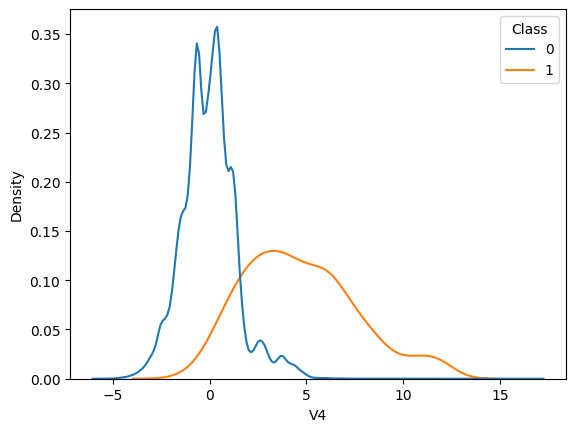

In [384]:
sns.kdeplot(data=data_train,x='V4', hue='Class', common_norm=False)

<Axes: xlabel='V10', ylabel='Density'>

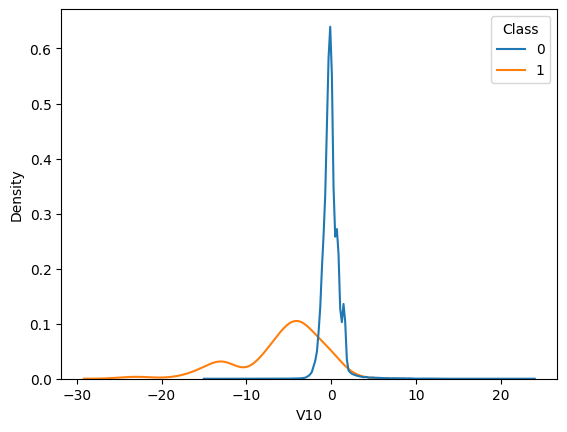

In [385]:
sns.kdeplot(data=data_train,x='V10', hue='Class', common_norm=False)

<Axes: xlabel='V1', ylabel='Density'>

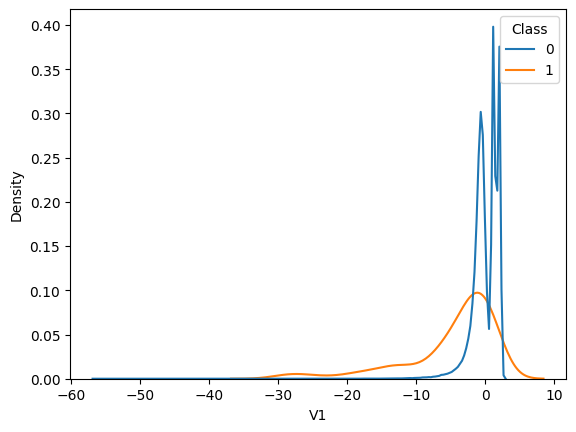

In [386]:
sns.kdeplot(data=data_train,x='V1', hue='Class', common_norm=False)

<Axes: xlabel='V4', ylabel='Density'>

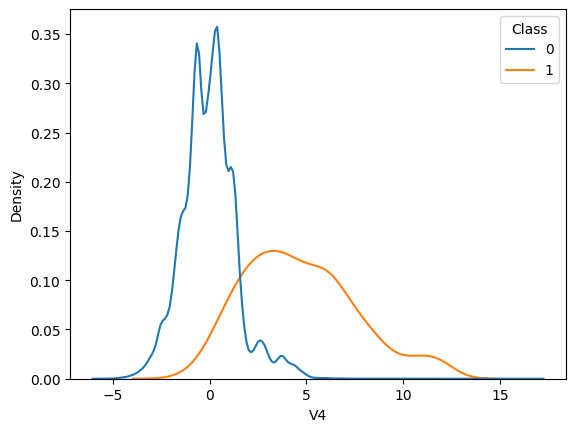

In [387]:
sns.kdeplot(data=data_train,x='V4', hue='Class', common_norm=False)

# Modeling

Modelagem:
    - Discutir as métricas 
        - AUC
        - F1
        - Recall
        - Precision 
        - Matriz de Confusão
        - Custo 
    - Discutir a metodologia
        - Uso de um baseline (Regressão Logística)
        - Modelo de boosting (catboost)
        - Calibração das probabilidades
            - Acrescentar que essa forma seria uma forma diferente de encarar o problema (integração com outros modelos, integrar com um mecanismo de decisão)
Conclusão
    - Salva o modelo joblib
    - API 
    Proximos Passos~
        - Passo de resampling para o hidden feedback loop
        - Sugestão de deploy 
        

## Baseline Model 


In [388]:
from sklearn.linear_model import lasso_path, LogisticRegression
from src.model import undersampling, calc_metrics, roc_auc_curve, conf_mat
from itertools import cycle
import shap




In [389]:
model_baseline = LogisticRegression()

In [390]:
# X_train = data_resampled[sel_feat]
# y_train = data_resampled[TARGET]
X_train = data_train[FEATURES]
y_train = data_train[TARGET]

X_test = data_test[FEATURES]
y_test = data_test[TARGET]

model_baseline.fit(X_train,y_train)

c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\fraud-detection-ofJXJpq--py3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [391]:
y_pred = model_baseline.predict(X_test)
scores = model_baseline.predict_proba(X_test)[:,1]

In [392]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [393]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.63,0.84,0.72,0.94,-6935.35


<Axes: xlabel='Predicted', ylabel='True'>

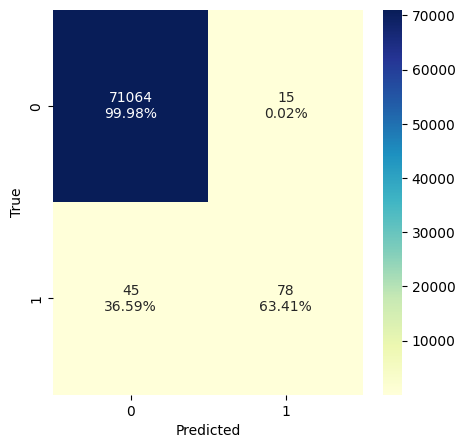

In [394]:
conf_mat(y_test, y_pred)

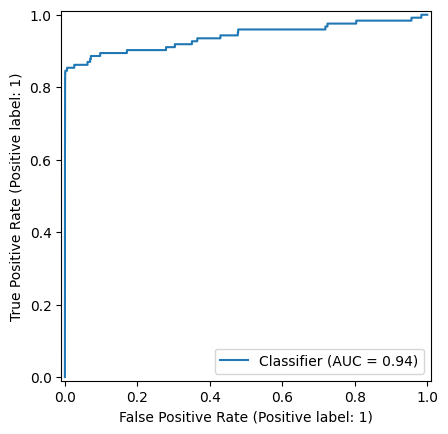

In [395]:
roc_auc_curve(y_test, scores)

## Undersampling

In [396]:
data_resampled = undersampling(data_train,prop=0.1) 

In [397]:
X_train = data_resampled[FEATURES]
y_train = data_resampled[TARGET]

model_baseline.fit(X_train,y_train)

c:\Users\thoma\AppData\Local\pypoetry\Cache\virtualenvs\fraud-detection-ofJXJpq--py3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [398]:
y_pred = model_baseline.predict(X_test)
scores = model_baseline.predict_proba(X_test)[:,1]

In [399]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [400]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.81,0.63,0.71,0.97,-2166.47


<Axes: xlabel='Predicted', ylabel='True'>

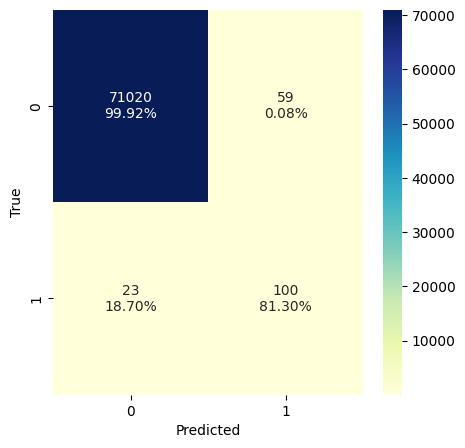

In [401]:
conf_mat(y_test, y_pred)

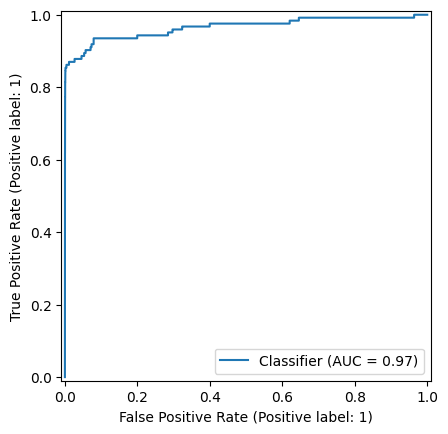

In [402]:
roc_auc_curve(y_test, scores)

## Boosting Model

In [403]:
from catboost import CatBoostClassifier

In [404]:
X_train = data_train[FEATURES]
y_train = data_train[TARGET]

X_test = data_test[FEATURES]
y_test = data_test[TARGET]

In [405]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)
clf.fit(X_train, y_train)

In [406]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [407]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [408]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.84,0.74,0.78,0.98,-2098.42


<Axes: xlabel='Predicted', ylabel='True'>

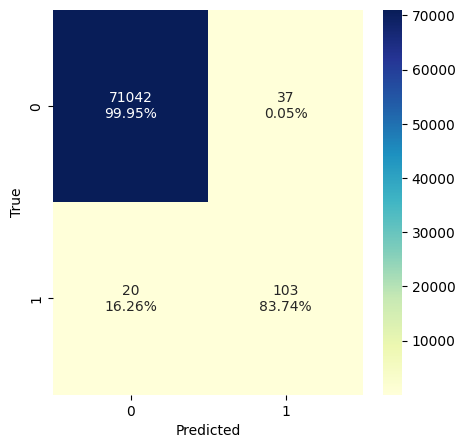

In [409]:
conf_mat(y_test, y_pred)

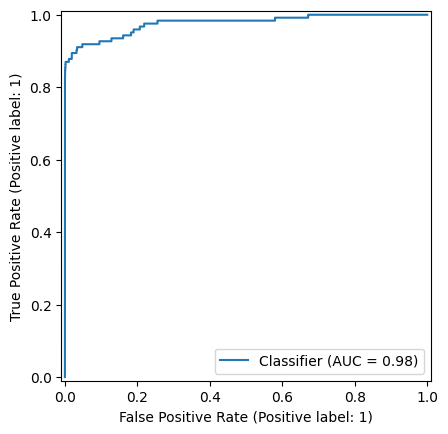

In [410]:
roc_auc_curve(y_test, scores)

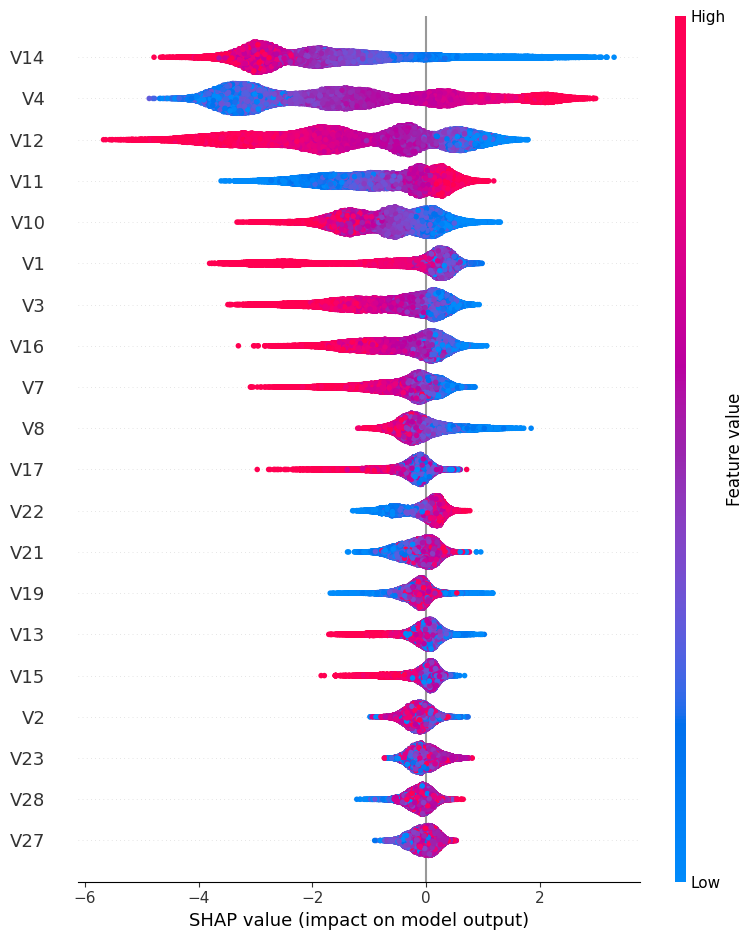

In [411]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## Feature Engineering

### Time Hour

In [412]:
data_train['hour'] = data_train['time_hr']%24
data_test['hour'] = data_test['time_hr']%24


In [413]:
new_features = FEATURES+['hour']

In [414]:
X_train = data_train[new_features]
y_train = data_train[TARGET]

X_test = data_test[new_features]
y_test = data_test[TARGET]

In [415]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)
clf.fit(X_train, y_train)

In [416]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [417]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [418]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.85,0.80,0.82,0.97,-2072.56


<Axes: xlabel='Predicted', ylabel='True'>

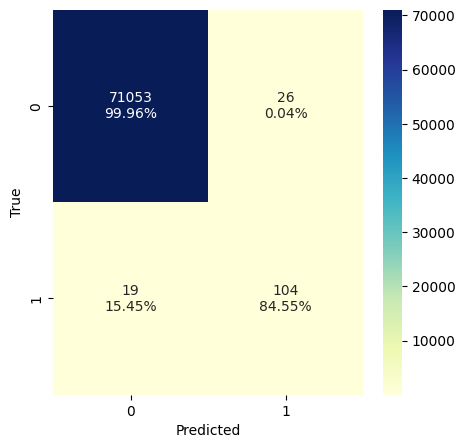

In [419]:
conf_mat(y_test, y_pred)

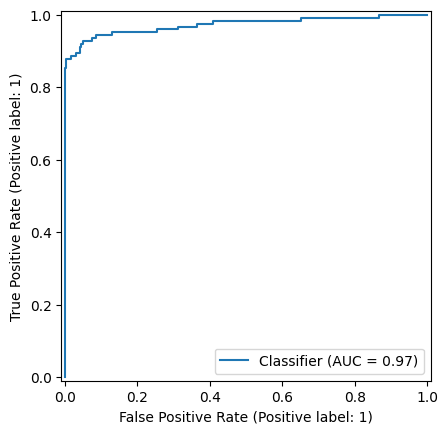

In [420]:
roc_auc_curve(y_test, scores)

### Distance Feature

In [421]:
df_frauds = data_train[data_train.Class==1]
df_no_frauds = data_train[data_train.Class==0]

In [422]:
centroid_n_fraud = df_no_frauds[FEATURES].mean()
centroid_fraud   = df_frauds[FEATURES].mean()
centroid_median_n_fraud = df_no_frauds[FEATURES].median()
centroid_median_fraud = df_frauds[FEATURES].median()

In [423]:
# print(f"Centroid not fraud: {centroid_n_fraud.values}")
# print(f"Centroid fraud: {centroid_fraud.values}")



In [424]:
# print(f"Centroid not fraud (median): {centroid_median_n_fraud.values}")
# print(f"Centroid fraud  (median):  {centroid_median_fraud.values}")

In [425]:
def calc_distance(df):
    data_points = df[FEATURES].values
    dist_n_fraud = np.linalg.norm(data_points-centroid_n_fraud.values)
    dist_fraud = np.linalg.norm(data_points-centroid_fraud.values)
    dist_median_n_fraud = np.linalg.norm(data_points-centroid_n_fraud.values)
    dist_median_fraud = np.linalg.norm(data_points-centroid_n_fraud.values)
    df = df.assign(dist_fraud = dist_fraud,
                   dist_n_fraud = dist_n_fraud,
                   dist_median_n_fraud = dist_median_n_fraud,
                   dist_median_fraud = dist_median_fraud)
    return df

In [426]:
data_train = calc_distance(data_train)
data_test =  calc_distance(data_test)

In [427]:
new_features = FEATURES + ['hour', 'dist_fraud', 'dist_n_fraud',
                           'dist_median_n_fraud', 'dist_median_fraud']

In [428]:
X_train = data_train[new_features]
y_train = data_train[TARGET]

X_test = data_test[new_features]
y_test = data_test[TARGET]

In [429]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)
clf.fit(X_train, y_train)

In [430]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [431]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [432]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.85,0.80,0.82,0.97,-2072.56


<Axes: xlabel='Predicted', ylabel='True'>

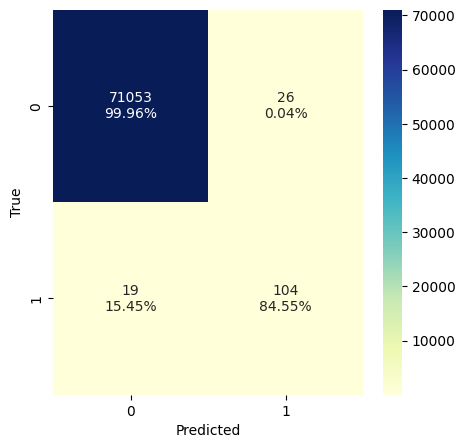

In [433]:
conf_mat(y_test, y_pred)

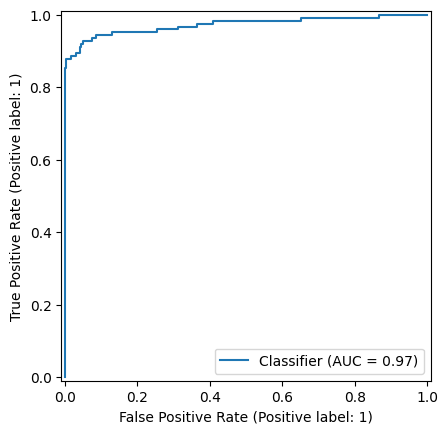

In [434]:
roc_auc_curve(y_test, scores)

In [435]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,V14,10.388448
1,V4,7.991448
2,V1,6.148725
3,V3,5.615606
4,V12,5.151583
5,V11,4.659775
6,V17,4.144383
7,V8,3.955205
8,V7,3.805440
9,V16,3.206781


## Tuning Threshold

In [484]:
new_features = FEATURES + ['hour']

In [485]:
X_train = data_train[new_features]
y_train = data_train[TARGET]

X_test = data_test[new_features]
y_test = data_test[TARGET]

In [ ]:
clf  = CatBoostClassifier(auto_class_weights = 'Balanced', 
                          verbose = False)

In [486]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [487]:
clf_tuned = TunedThresholdClassifierCV(clf,scoring="f1_micro").fit(X_train,y_train)


In [488]:
clf_tuned.best_threshold_

0.9898915510867115

In [489]:
y_pred = clf.predict(X_test)
scores = clf.predict_proba(X_test)[:,1]

In [490]:
data_test_scored = data_test.assign(y_pred = y_pred,
                                    scores = scores,
                                    y_true = y_test)

In [491]:
calc_metrics(data_test_scored)


,recall,precision,f1,auc,Cost
value,0.85,0.80,0.82,0.97,-2072.56


<Axes: xlabel='Predicted', ylabel='True'>

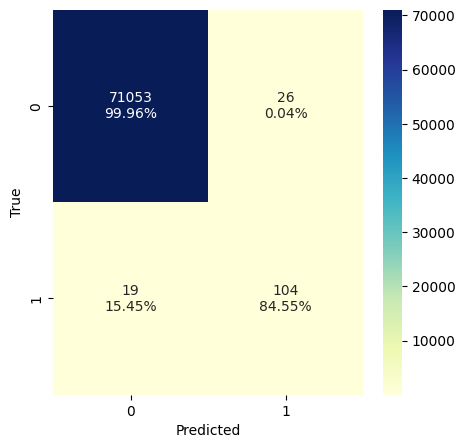

In [492]:
conf_mat(y_test, y_pred)

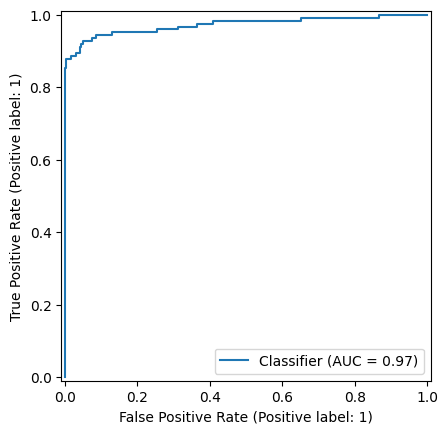

In [493]:
roc_auc_curve(y_test, scores)

## Calibração 

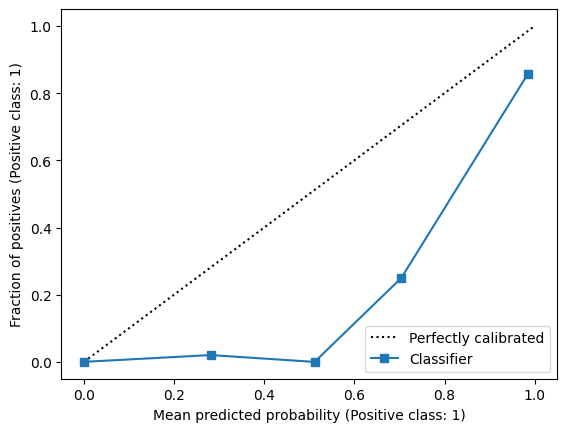

In [444]:
CalibrationDisplay.from_predictions(y_test,scores)

In [445]:
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

In [446]:
calibrated_clf = CalibratedClassifierCV(clf, cv=3)


In [447]:
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=3,
                       estimator=<catboost.core.CatBoostClassifier object at 0x00000175E0CC5AC0>)

In [448]:
scores = calibrated_clf.predict_proba(X_test)[:,1]

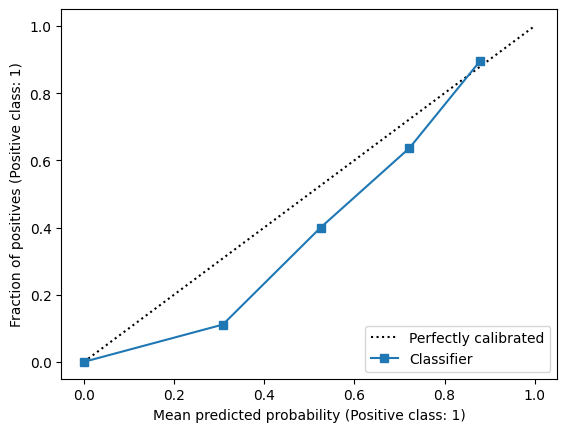

In [449]:
CalibrationDisplay.from_predictions(y_test,scores)

In [450]:
pd.Series(scores).describe()

count    71202.000000
mean         0.001786
std          0.035190
min          0.000286
25%          0.000287
50%          0.000287
75%          0.000287
max          0.883958
dtype: float64

In [451]:
# data_test['scores'] = scores
# bin_var(data_test,'scores')

In [452]:
from optbinning import OptimalBinning
# 

In [453]:
# optb = OptimalBinning(name='scores',max_n_bins=10, dtype="numerical", solver="cp")


In [454]:
# optb.fit(scores,y_test)

In [455]:
# optb.binning_table.build()

# Save Model

In [457]:
import joblib

In [458]:
joblib.dump(clf_tuned, "../assets/model_clf.joblib")

['../assets/model_clf.joblib']

In [459]:
joblib.dump(calibrated_clf, "../assets/model_score.joblib")

['../assets/model_score.joblib']

In [521]:
s= data_test.sample(1)
a=  s[FEATURES]

In [532]:
s = X_test[scores>0.5].iloc[0,:]

In [568]:
s.to_dict()

{'V1': -17.2751911945397,
 'V2': 10.8196653713117,
 'V3': -20.3638859739149,
 'V4': 6.04661174671427,
 'V5': -13.4650333517322,
 'V6': -4.16664724489873,
 'V7': -14.4094479851747,
 'V8': 11.5807967244857,
 'V9': -4.07385571204177,
 'V10': -9.15336803834587,
 'V11': 6.21088301172371,
 'V12': -8.77857203246194,
 'V13': -0.0613674966661798,
 'V14': -9.57466229922106,
 'V15': 0.0492885399107771,
 'V16': -7.41848727872681,
 'V17': -14.1027718764864,
 'V18': -5.01642333521081,
 'V19': 1.39031436050276,
 'V20': 1.54497046707519,
 'V21': 1.7298040916597,
 'V22': -1.20809608165502,
 'V23': -0.726839224163999,
 'V24': 0.112539673508366,
 'V25': 1.11919347248491,
 'V26': -0.233188990129274,
 'V27': 1.68406299250578,
 'V28': 0.503739738280361,
 'Amount': 99.99,
 'hour': 7.0}

In [539]:
s.values

array([-1.72751912e+01,  1.08196654e+01, -2.03638860e+01,  6.04661175e+00,
       -1.34650334e+01, -4.16664724e+00, -1.44094480e+01,  1.15807967e+01,
       -4.07385571e+00, -9.15336804e+00,  6.21088301e+00, -8.77857203e+00,
       -6.13674967e-02, -9.57466230e+00,  4.92885399e-02, -7.41848728e+00,
       -1.41027719e+01, -5.01642334e+00,  1.39031436e+00,  1.54497047e+00,
        1.72980409e+00, -1.20809608e+00, -7.26839224e-01,  1.12539674e-01,
        1.11919347e+00, -2.33188990e-01,  1.68406299e+00,  5.03739738e-01,
        9.99900000e+01,  7.00000000e+00])

# Test API

In [576]:
import requests
import json

In [577]:

with open("../assets/sample.json") as f: 
    sample = json.load(f)

In [578]:
requests.get('http://127.0.0.1:8000/predict',data=json.dumps(sample)).json()

{'id': 'S001', 'prediction': 'Not Fraud'}

In [580]:
with open("../assets/sample_fraud.json") as f: 
    sample = json.load(f)

In [581]:
r = requests.get('http://127.0.0.1:8000/predict',data=json.dumps(sample))

In [582]:
r.json()

{'id': 'S002', 'prediction': '88.278%'}